In [1]:
import numpy as np
import pylab as pb
import GPy
import copy as cp
import pickle

from cassL import camb_interface as ci
from cassL import generate_emu_data as ged
from cassL import user_interface as ui

regenerate = True

linear_in_sigma12 = False

pb.ion()

file_base = ""

In [2]:
assert False, "you should give this emulator a new name instead of over-writing"
emu_vlabel = "Hnu3"

In [4]:
# X_raw = np.load("hc_G6_pred_r1.npy", allow_pickle=True)
# Y_raw = np.load("samples_G6_pred_r1.npy", allow_pickle=True)

# We don't use the emu_vlabel variable in the following code because the lhc
# version has decoupled from the emulator version.
if linear_in_sigma12:
    X_raw = np.load("hc_backup_i99_H3_unit_train.npy", allow_pickle=True)
    Y_raw = np.load("samples_backup_i99_H3_unit_train.npy", allow_pickle=True)
else:
    #X_raw = np.load("hc_backup_i499_H2_train.npy", allow_pickle=True)
    #Y_raw = np.load("samples_backup_i499_H2_train.npy", allow_pickle=True)  
    X_raw = np.load("hc_backup_i4999_H3_unit_train.npy", allow_pickle=True)
    Y_raw = np.load("samples_backup_i4999_H3_unit_train.npy", allow_pickle=True)  


In [5]:
scales = np.load("standard_k.npy", allow_pickle=True)

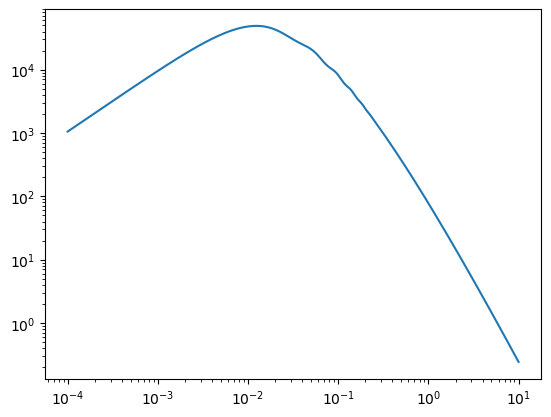

In [6]:
# This plot only serves to make sure that the first row actually describes a
# function.
pb.loglog(scales, Y_raw[0])

In [7]:
def is_bad(row):
    if float('-inf') in row or float('inf') in row \
        or None in row or True in np.isnan(pspec) \
        or 0 in row:
        return True
    return False

bad_row_indices = []
for i in range(len(Y_raw)):
    pspec = Y_raw[i]
    if is_bad(pspec):
        bad_row_indices.append(i)

X = np.delete(X_raw, bad_row_indices, 0)
Y = np.delete(Y_raw, bad_row_indices, 0)

In [8]:
# Now the goal is to compute summary statistics on Y for each value k
Ylog = np.log(Y)
ymu = np.mean(Ylog, axis=0)
ymu.shape
ystdev = np.std(Ylog, axis=0)
ystdev.shape

(300,)

In [9]:
# now normalize the data with these summary statistics
Y_normalized = cp.deepcopy(Ylog)

for i in range(len(Y)):
    Y_normalized[i] -= ymu
    Y_normalized[i] /= ystdev

In [10]:
par_ranges = ui.get_param_ranges(massive_neutrinos=True)
if not linear_in_sigma12:
    del par_ranges['sigma12']
    par_ranges['sigma12_2'] = [0.04, 1]

In [11]:
par_ranges

{'ombh2': [0.0205, 0.02415],
 'omch2': [0.085, 0.155],
 'n_s': [0.92, 1.01],
 'A_s': [1.15e-09, 4.989895197340787e-09],
 'omnuh2': [0.0, 0.01],
 'sigma12_2': [0.04, 1]}

In [12]:
xmin = np.array([])
xrange = np.array([])

if linear_in_sigma12:
    for key in par_ranges.keys():
        xmin = np.append(xmin, par_ranges[key][0])
        xrange = np.append(xrange, par_ranges[key][1] - par_ranges[key][0])

else:
    for key in par_ranges.keys():
        xmin = np.append(xmin, par_ranges[key][0])
        xrange = np.append(xrange, par_ranges[key][1] - par_ranges[key][0])
        if key == "n_s":
            xmin = np.append(xmin, 0)
            xrange = np.append(xrange, 0)
        if key == "omnuh2":
            break
    
    xmin[3] = 0.04
    xrange[3] = 0.96

print(xmin)
print(xrange)

[2.05e-02 8.50e-02 9.20e-01 4.00e-02 1.15e-09 0.00e+00]
[3.6500000e-03 7.0000000e-02 9.0000000e-02 9.6000000e-01 3.8398952e-09
 1.0000000e-02]


In [13]:
def inverse_ytransform(raw_prediction):
    return np.exp(raw_prediction * ystdev + ymu)

In [14]:
def xtransform(configuration):
    return (configuration - xmin) / xrange

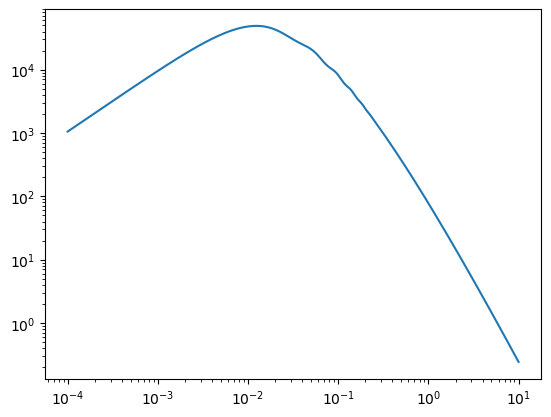

In [15]:
pb.loglog(scales, inverse_ytransform(Y_normalized[0]))

In [16]:
print(X.shape, Y_normalized.shape)

(5000, 6) (5000, 300)


In [17]:
test_omnuh2 = 0.002

m0_without_neuts = ci.specify_neutrino_mass(ci.cosm.iloc[0], 0, 0)
m0_with_neuts = ci.specify_neutrino_mass(ci.cosm.iloc[0], test_omnuh2, 1)

m0_with_neuts['omch2'] -= test_omnuh2

In [18]:
# We'll need to check our work using CAMB
p_true_interpolator = ci.andrea_interpolator(m0_with_neuts)#,
#    redshifts=[0], kmax=10)
p_m0truth = np.array([p_true_interpolator.P(0, k) for k in scales])

s_m0truth = ci.s12_from_interpolator(p_true_interpolator, 0)

m0_without_neuts['sigma12'] = m0_with_neuts['sigma12'] = s_m0truth

print(s_m0truth)

nnu_massive: 1
0.7864558724216139


In [19]:
p_m0truth2, actual_sigma12, best_z = ged.interpolate_cell(m0_with_neuts, scales,
    using_andrea_code=False)

In [20]:
kernel = GPy.kern.RBF(input_dim=6, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(X, Y_normalized, kernel)

In [21]:
if regenerate:
    m.constrain_positive('') # '' is a regex matching all parameter names
    m.optimize()
    
    m.ymu = ymu
    m.ystdev = ystdev
    m.xmin = xmin
    m.xrange = xrange
    pickle.dump(m, open("analyses/massive_emulator_" + emu_vlabel + ".cle", "wb"), protocol=5) 
else:
    m = pickle.load(open("analyses/massive_emulator_" + emu_vlabel + ".cle", "rb"))

In [22]:
# Remember that the structure of an hc entry is DIFFERENT NOW
# omb, omc, ns, s12, As, omnu
x = np.array([np.array([
    m0_with_neuts['ombh2'], m0_with_neuts['omch2'], m0_with_neuts['n_s'],
    s_m0truth, m0_with_neuts['A_s'], m0_with_neuts['omnuh2']
])])
x

array([[2.24450000e-02, 1.18567000e-01, 9.60000000e-01, 7.86455872e-01,
        2.12723788e-09, 2.00000000e-03]])

In [23]:
if not linear_in_sigma12:
    x[0][3] *= x[0][3]

In [24]:
# guess, uncertainties = m.predict(xtransform(x))
guess, uncertainties = m.predict(xtransform(x))

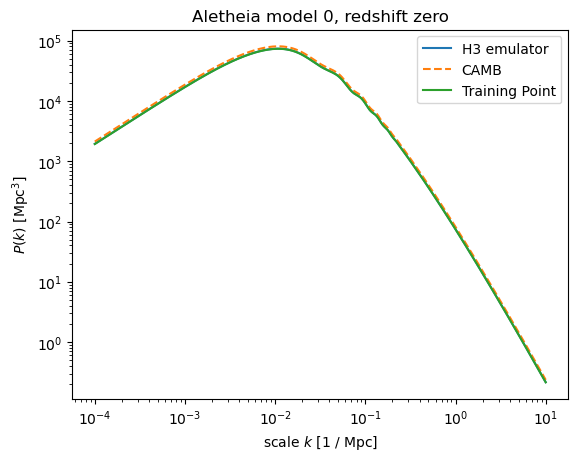

In [25]:
pb.plot(scales, inverse_ytransform(guess[0]), label=emu_vlabel + " emulator")
pb.loglog(scales, p_m0truth, label="CAMB", linestyle='dashed')
pb.loglog(scales, p_m0truth2, label="Training Point")#, linestyle='dashed')
pb.title("Aletheia model 0, redshift zero")
pb.ylabel('$P(k)$ [Mpc$^3$]')
pb.xlabel('scale $k$ [1 / Mpc]')
pb.legend()

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

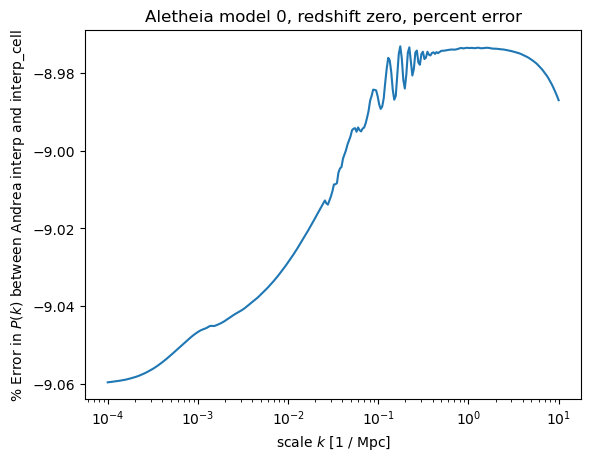

In [26]:
pb.plot(scales,
    ui.percent_error(p_m0truth, p_m0truth2))
pb.xscale('log')
pb.title("Aletheia model 0, redshift zero, percent error")
pb.ylabel('% Error in $P(k)$ between Andrea interp and interp_cell')
pb.xlabel('scale $k$ [1 / Mpc]')
# pb.savefig("../../plots/emulator/performance/massive_m0_G5.png")

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

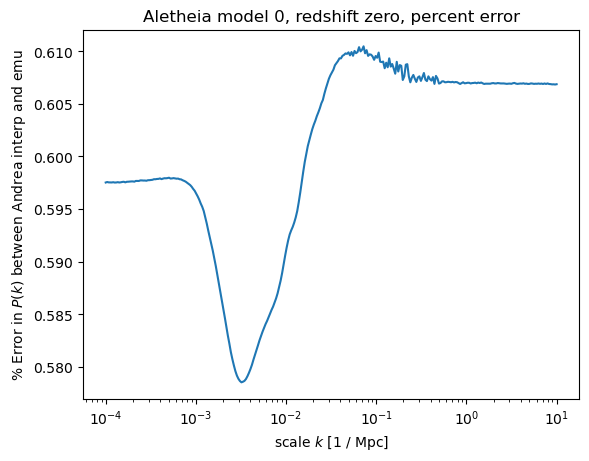

In [27]:
pb.plot(scales,
    ui.percent_error(p_m0truth2, inverse_ytransform(guess[0])))
pb.xscale('log')
pb.title("Aletheia model 0, redshift zero, percent error")
pb.ylabel('% Error in $P(k)$ between Andrea interp and emu')
pb.xlabel('scale $k$ [1 / Mpc]')
# pb.savefig("../../plots/emulator/performance/massive_m0_G5.png")

In [28]:
# Remember that the structure of an hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_ns = np.array([np.array([
    0.022445, 0.120567, 1.01, 0.82466774,
    2.12723788013000E-09, 0
])])
guess_hi_ns, uncertainties_hi_ns = m.predict(x_hi_ns)
x_lo_ns = np.array([np.array([
    0.022445, 0.120567, 0.92, 0.82466774,
    2.12723788013000E-09, 0
])])
guess_lo_ns, uncertainties_lo_ns = m.predict(xtransform(x_lo_ns))


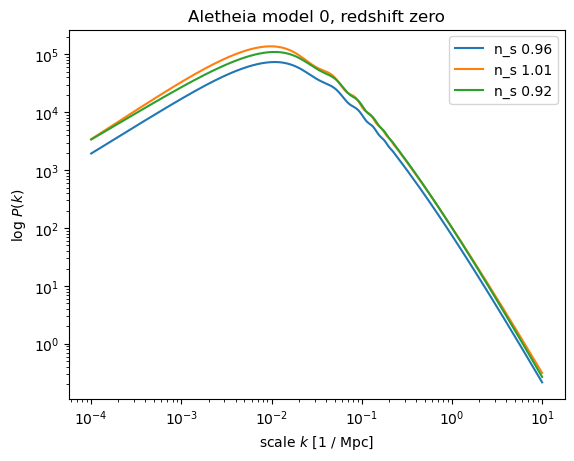

In [29]:
pb.loglog(scales, inverse_ytransform(guess[0]), label="n_s 0.96")
pb.loglog(scales, inverse_ytransform(guess_hi_ns[0]), label="n_s 1.01")
pb.loglog(scales, inverse_ytransform(guess_lo_ns[0]), label="n_s 0.92")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel('scale $k$ [1 / Mpc]')
pb.legend()

In [30]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
omnu_hi = 0.01
x_hi_omnu = np.array([np.array([
    0.022445, 0.120567 - omnu_hi, 0.96, 0.82466774,
    2.12723788013000E-09, omnu_hi
])])
guess_hi_omnu, uncertainties_hi_omnu = m.predict(xtransform(x_hi_omnu))

omnu_mid = 0.002148659574468
x_mid_omnu = np.array([np.array([
    0.022445, 0.120567 - omnu_mid, 0.96, 0.82466774,
    2.12723788013000E-09, omnu_mid,
])])
guess_mid_omnu, uncertainties_mid_omnu = m.predict(xtransform(x_mid_omnu))


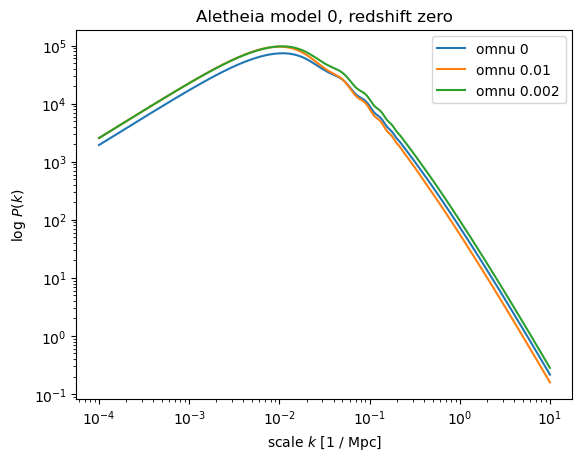

In [31]:
pb.loglog(scales, inverse_ytransform(guess[0]),
          label="omnu 0")
pb.loglog(scales, inverse_ytransform(guess_hi_omnu[0]),
          label="omnu 0.01")
pb.loglog(scales, inverse_ytransform(guess_mid_omnu[0]),
          label="omnu 0.002")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel("scale $k$ [1 / Mpc]")
pb.legend()

In [32]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_omb = np.array([np.array([
    0.02415, 0.120567, 0.96, 0.82466774,
    2.12723788013000E-09, 0
])])
guess_hi_omb, uncertainties_hi_omb = m.predict(xtransform(x_hi_omb))

x_lo_omb = np.array([np.array([
    0.0205, 0.120567, 0.96, 0.82466774,
    2.12723788013000E-09, 0
])])
guess_lo_omb, uncertainties_lo_omb = m.predict(xtransform(x_lo_omb))


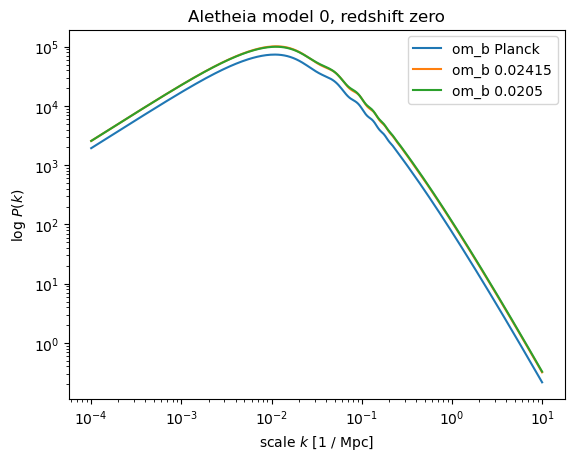

In [33]:
pb.loglog(scales, inverse_ytransform(guess[0]),
        label="om_b Planck")
pb.loglog(scales, inverse_ytransform(guess_hi_omb[0]),
        label="om_b 0.02415")
pb.loglog(scales, inverse_ytransform(guess_lo_omb[0]),
        label="om_b 0.0205")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel("scale $k$ [1 / Mpc]")
pb.legend()

In [34]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_omc = np.array([np.array([
    0.022445, 0.155, 0.96, 0.82466774,
    2.12723788013000E-09, 0
])])
guess_hi_omc, uncertainties_hi_omc = m.predict(xtransform(x_hi_omc))

x_lo_omc = np.array([np.array([
    0.022445, 0.085, 0.96, 0.82466774,
    2.12723788013000E-09, 0
])])
guess_lo_omc, uncertainties_lo_omc = m.predict(xtransform(x_lo_omc))


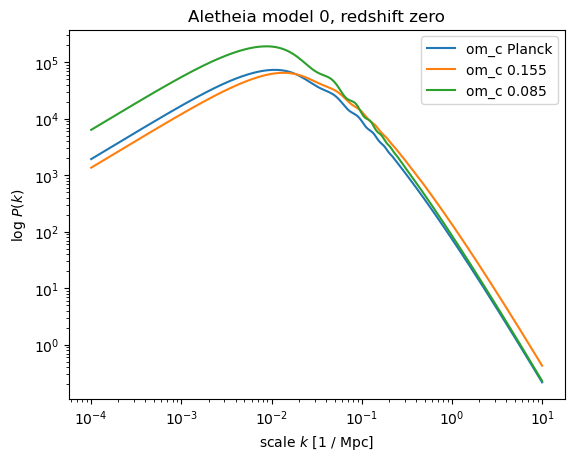

In [35]:
pb.loglog(scales, inverse_ytransform(guess[0]),
        label="om_c Planck")
pb.loglog(scales, inverse_ytransform(guess_hi_omc[0]),
        label="om_c 0.155")
pb.loglog(scales, inverse_ytransform(guess_lo_omc[0]),
        label="om_c 0.085")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel("scale $k$ [1 / Mpc]")
pb.legend()

In [36]:
# Remember that the structure of a hc entry is
# omb, omc, ns, s12, omnu, As
x_hi_As = np.array([np.array([
    0.022445, 0.120567, 0.96, 0.82466774,
    np.exp(3.91) / 10 ** 10, 0
])])
guess_hi_As, uncertainties_hi_As = m.predict(xtransform(x_hi_As))
x_lo_As = np.array([np.array([
    0.022445, 0.120567, 0.96, 0.82466774,
    np.exp(2.35) / 10 ** 10, 0
])])
guess_lo_As, uncertainties_lo_As = m.predict(xtransform(x_lo_As))

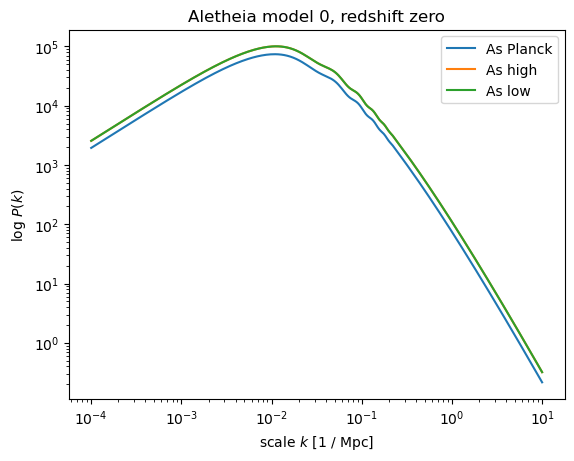

In [37]:
pb.loglog(scales, inverse_ytransform(guess[0]), label="As Planck")
pb.loglog(scales, inverse_ytransform(guess_hi_As[0]), label="As high")
pb.loglog(scales, inverse_ytransform(guess_lo_As[0]), label="As low")

pb.title("Aletheia model 0, redshift zero")
pb.ylabel('log $P(k)$')
pb.xlabel("scale $k$ [1 / Mpc]")
pb.legend()